# Exercise 1

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.special import erfc
import os

In [94]:
os.makedirs('media', exist_ok=True)

### 1.1 Vibrating string

A. (0.5 point) Discretize the wave equation, and write it in a form suitable for
implementing in a computer program. Assume that the boundaries are fixed, 	(x =
0, t) = 0, 	(x = L, t) = 0. L is the length of the string. Take L = 1 for simplicity.
Divide the string in N intervals, so that the interval length is x = L/N. Also
consider the boundary cases.

In [95]:
def solve_wave_equation(psi_init, L, c, T, Nx, dt):
    """Solves the wave equation using the finite difference method (explicit scheme) and returns the vibration amplitude psi(x,t) matrix of all time steps.
    
    Args:
    psi_init (function): Initial condition function to generate psi(x,0)
    L (float): Length of the string
    c (float): Wave speed
    T (float): Total time to simulate
    Nx (int): Total number of spatial intervals
    dt (float): Time step size
    """
    # Discretization
    dx = L/Nx # spatial step size
    Nt = int(T/dt)+1 # Total number of time steps
    psi = np.zeros((Nx+1, Nt)) # Vibration amplitude psi(x,t) matrix
    x = np.linspace(0, L, Nx+1) # spatial grid

    # Initial conditions
    psi[:,0] = psi_init(x)
    psi[:,1] = (1+dt)*psi[:,0] # approximated state at t=1

    # Physical boundaries at x=0 and x=L
    psi[0,:] = 0
    psi[-1,:] = 0

    # Stepping through time
    for t in range(2, Nt):
        for x in range(1, Nx): # exclude simulating at boundaries
            psi[x, t] = c**2 * (dt**2)/(dx**2) * (psi[x+1, t-1] + psi[x-1, t-1] - 2*psi[x, t-1]) - psi[x, t-2] + 2*psi[x, t-1]
    
    return psi

# Parameters
L = 1  # Length of the string
c = 1  # Wave speed
psi_init = lambda x: np.sin(2 * np.pi * x)

# Discretization
Nx = 100  # Total number of spatial intervals
dx = L / Nx  # Spatial step size
Nt = 1000  # Number of time steps to simulate
dt = 0.001  # Time step size

psi = solve_wave_equation(psi_init, L, c, Nt * dt, Nx, dt)
x = np.linspace(0, L, Nx)

B. (1 point) Implement the time stepping. Determine the time development of
the string, with the following initial conditions. The string is at rest at t = 0, i.e.
	′(x, t = 0) = 0.

i. 	(x, t = 0) = sin(2πx).

ii. 	(x, t = 0) = sin(5πx).

iii. 	(x, t = 0) = sin(5πx) if 1/5 < x < 2/5, else 	 = 0.

Take c = 1 and use the time step dt = 0.001. Plot the result at several times in
the same figure, e.g. varying the color of the curve.

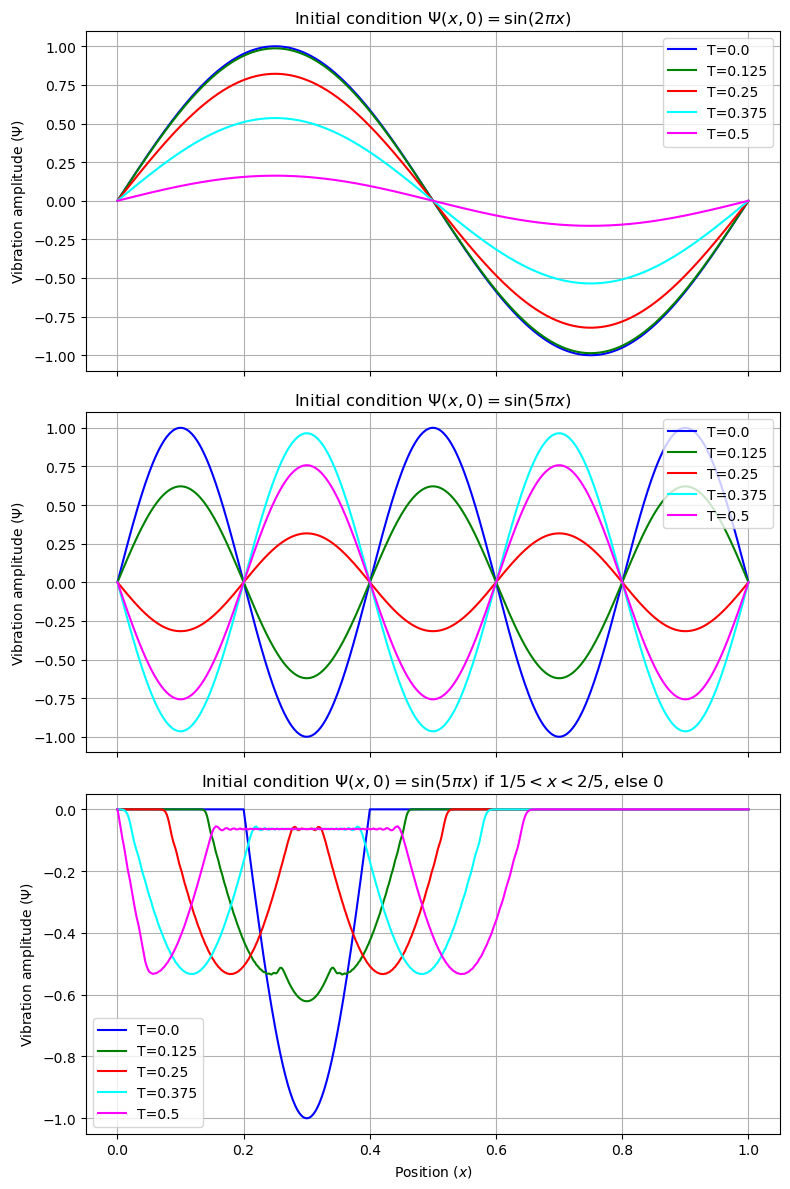

In [103]:
# Parameters
c = 1
L = 1

# Discretization
dt = 0.001
T = 0.5
Nx = 500
dx = L / Nx
Nt = int(T / dt)

init_conditions = [
    lambda x: np.sin(2 * np.pi * x),
    lambda x: np.sin(5 * np.pi * x),
    lambda x: np.where((1/5 < x) & (x < 2/5), np.sin(5 * np.pi * x), 0)
]

init_labels = [
    '$\\sin(2\\pi x)$',
    '$\\sin(5\\pi x)$',
    '$\\sin(5\\pi x)$ if $1/5 < x < 2/5$, else $0$'
]

psis = []
for i, (f0, init_label) in enumerate(zip(init_conditions, init_labels)):
    psi = solve_wave_equation(f0, L, c, T, Nx, dt)
    psis.append(psi)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True, layout='tight')
times = np.linspace(0, T, 5)
time_labels = [f'T={t}' for t in times]
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
x = np.linspace(0, L, Nx+1)

for i, (psi, init_label) in enumerate(zip(psis, init_labels)):
    for j, (time, time_label, color) in enumerate(zip(times, time_labels, colors)):
        axs[i].plot(x, psi[:, int(Nt*time)], label=time_label, color=color)
    axs[i].set_ylabel('Vibration amplitude ($\\Psi$)')
    axs[i].set_title(f'Initial condition $\\Psi(x,0)=${init_label}')
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('Position ($x$)')
plt.savefig('media/wave_equation.png', dpi=300, bbox_inches='tight')
plt.show()

C. (1 point) Make an animated plot of the time development.

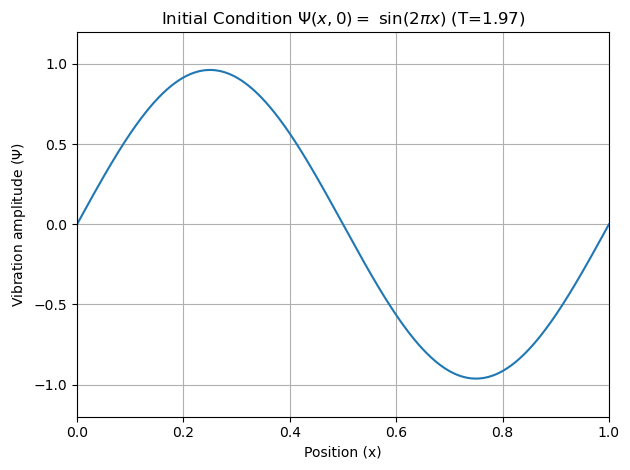

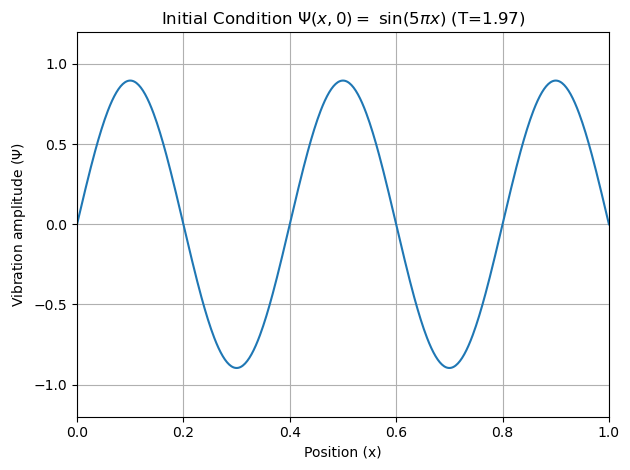

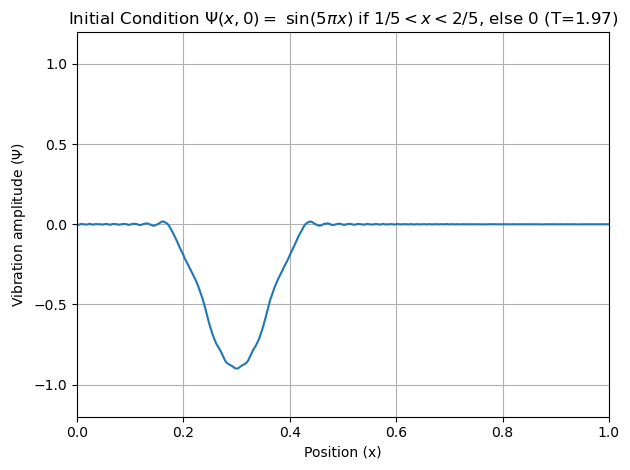

In [106]:
# Parameters
c = 1
L = 1

# Discretization
dt = 0.001
T = 2.0
Nx = 500
dx = L / Nx
Nt = int(T / dt)

def animate_wave_equation(psi, title, file_title, L=1.0, T=1.0, total_frames=100, save=False):
    fig, ax = plt.subplots(layout='tight')
    x = np.linspace(0, L, psi.shape[0])
    plt.xlim(0, L)
    plt.ylim(-1.2, 1.2)
    plt.xlabel('Position (x)')
    plt.ylabel('Vibration amplitude ($\\Psi$)')
    plt.grid(True)
    line, = ax.plot(x, psi[:,0])

    # Calculate the frame interval based on the total number of frames
    frame_interval = int(psi.shape[1] / total_frames)

    def animate(i):
        line.set_ydata(psi[:,i * frame_interval])
        plt.title(title + f' (T={i * frame_interval / psi.shape[1] * T:.2f})')
        return line,

    anim = FuncAnimation(fig, animate, frames=total_frames, interval=1000//60, blit=True, repeat=True)
    if save:
        anim.save(f'media/{file_title}.gif', writer='ffmpeg')

for i, (psi, init_label) in enumerate(zip(psis, init_labels)):
    psi = solve_wave_equation(init_conditions[i], L, c, T, Nx, dt)
    anim = animate_wave_equation(psi, f'Initial Condition $\\Psi(x,0) =$ {init_label}', f'animated_wave_{i}', T=T, total_frames=80, save=True)

### 1.2: Time Dependent Diffusion Equation

D. (0.5 point) Determine the equation to use at the boundaries of the domain.
Clearly show the ranges of the indices of the grid. A figure is extremely helpful for
figuring this out.

In [98]:
total_time = 1
D = 1
Nx = 50
L = 1

# Adjust time step based on stability condition
dt_stable = (dx**2) / (4 * D)  # Stability condition for dt
if dt > dt_stable:
    dt = dt_stable / 2  # Choose a dt smaller than the maximum stable dt to ensure stability
num_steps = int(total_time / dt)  # Recalculate number of time steps based on new dt

# Re-initialize concentration field with boundary conditions
c = np.zeros((Nx, Nx))
c[:, 0] = 0  # c(x, y=0) = 0
c[:, -1] = 1  # c(x, y=1) = 1
# Initial condition assumed to be zero everywhere else

# Update function using vectorized operations for better performance
def update_vectorized(u):
    u_new = np.copy(u)
    u_new[1:-1, 1:-1] = u[1:-1, 1:-1] + (D * dt / dx**2) * (
        u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] - 4 * u[1:-1, 1:-1])
    # Apply periodic boundary conditions
    u_new[:, 0] = u_new[:, -2]  # Left boundary
    u_new[:, -1] = u_new[:, 1]  # Right boundary
    return u_new

# Re-run simulation with adjusted dt and vectorized update
for step in range(num_steps):
    c = update_vectorized(c)

# Plotting the final state after adjustments
plt.figure(figsize=(8, 6))
plt.imshow(c, extent=[0, L, 0, L], origin='lower', cmap='hot')
plt.colorbar(label='Concentration')
plt.title('Concentration at t={:.2f}s (Stable Configuration)'.format(total_time))
plt.xlabel('x')
plt.ylabel('y')
plt.show()


KeyboardInterrupt: 

E. (1 point) Test the correctness of your simulation. Compare to the analytic
solutions, plot c(y) for different times.

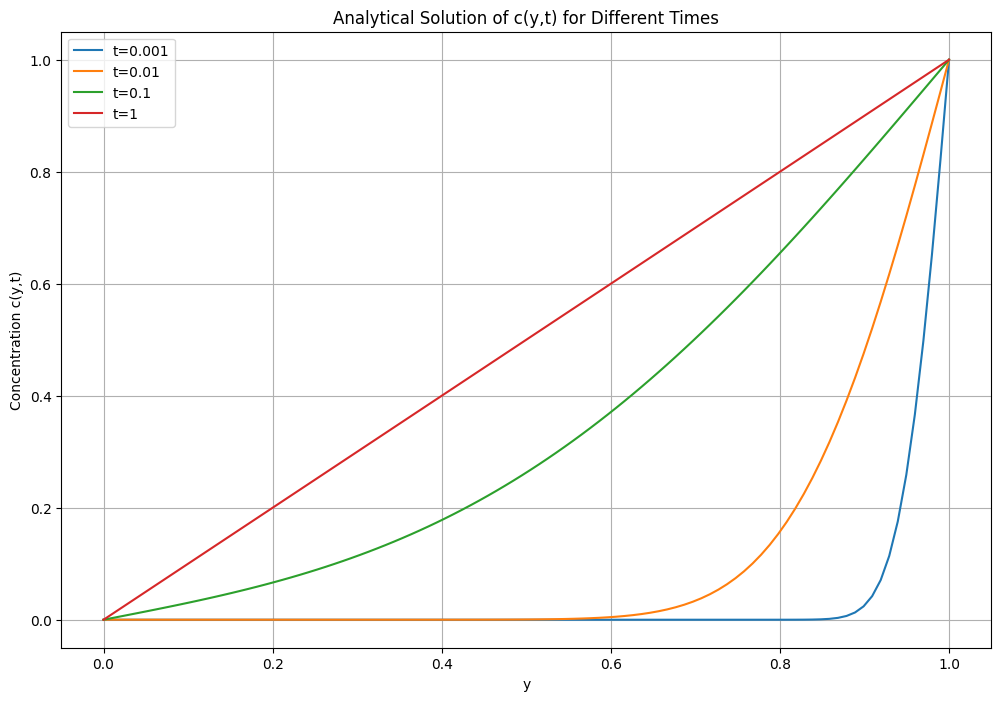

In [ ]:
# Diffusion constant
D = 1

# Function to compute the analytical solution for a given y and t
def analytical_solution(y, t, terms=50):
    result = 0
    for i in range(terms):
        result += erfc((1 - y + 2*i) / np.sqrt(4*D*t)) - erfc((1 + y + 2*i) / np.sqrt(4*D*t))
    return result

# y values for plotting
y_values = np.linspace(0, 1, 100)

# Time values for which the solutions will be plotted
time_values = [0.001, 0.01, 0.1, 1]

# Plotting
plt.figure(figsize=(12, 8))
for t in time_values:
    plt.plot(y_values, analytical_solution(y_values, t), label=f't={t}')

plt.title('Analytical Solution of c(y,t) for Different Times')
plt.xlabel('y')
plt.ylabel('Concentration c(y,t)')
plt.legend()
plt.grid(True)
plt.show()


F. (1 point) Plot the results, show the 2D domain, with a color representing the
concentration at each point. Make a plot of the state of the system at several times:
t = {0, 0.001, 0.01, 0.1, and 1}.

KeyError: 1

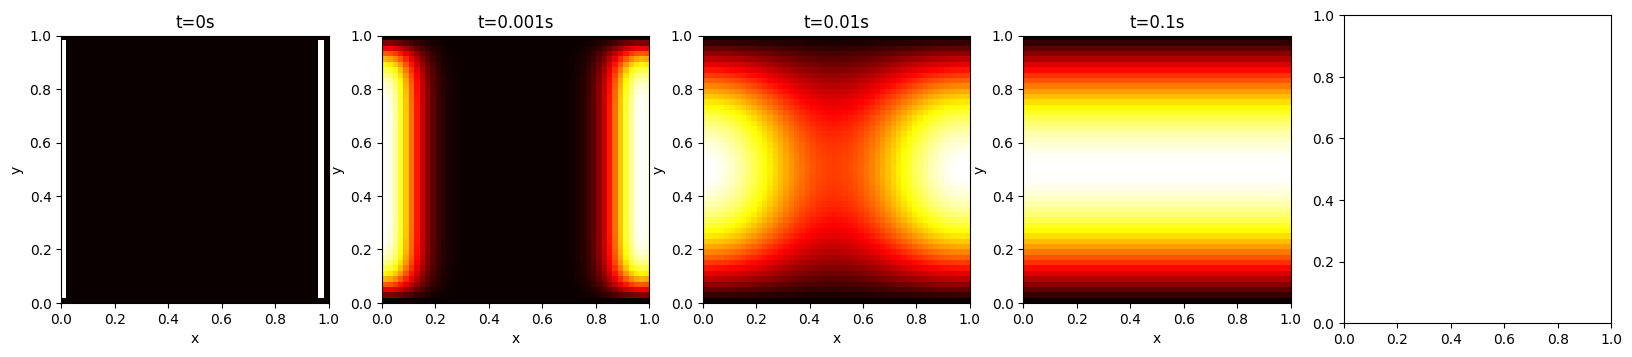

In [ ]:
# Adjusted simulation to capture specific time states with a tolerance for floating-point comparison
def simulate_diffusion_with_tolerance(N, D, dx, dt, total_times, tolerance=1e-5):
    """
    Simulate diffusion and return the concentration at specified times with a tolerance for time comparison.

    Parameters:
    - N: Number of grid points
    - D: Diffusion constant
    - dx: Distance between grid points
    - dt: Time step
    - total_times: List of times at which to record the concentration
    - tolerance: Tolerance for comparing floating-point times

    Returns:
    - A dictionary with times as keys and concentration grids as values
    """
    c = np.zeros((N, N))
    c[:, 0] = 0
    c[:, -1] = 1
    
    concentration_at_times = {}
    current_time = 0.0
    step = 0
    
    while current_time <= max(total_times):
        c[1:-1, 1:-1] = c[1:-1, 1:-1] + (D * dt / dx**2) * (
            c[2:, 1:-1] + c[:-2, 1:-1] + c[1:-1, 2:] + c[1:-1, :-2] - 4 * c[1:-1, 1:-1])
        c[:, 0] = c[:, -2]  # Left boundary
        c[:, -1] = c[:, 1]  # Right boundary
        
        # Check if the current time is close enough to any of the specified times
        for time in total_times:
            if np.abs(current_time - time) < tolerance:
                concentration_at_times[time] = np.copy(c)
        
        current_time += dt
        step += 1
    
    return concentration_at_times

# Time points to capture the concentration
times_to_plot = [0, 0.001, 0.01, 0.1, 1]

# Recalculate the simulation with tolerance for capturing times
results_with_tolerance = simulate_diffusion_with_tolerance(Nx, D, dx, dt, times_to_plot)

# Plotting with corrected results
fig, axs = plt.subplots(1, len(times_to_plot), figsize=(20, 4))
for i, time in enumerate(times_to_plot):
    axs[i].imshow(results_with_tolerance[time], extent=[0, L, 0, L], origin='lower', cmap='hot')
    axs[i].set_title(f't={time}s')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')

plt.tight_layout()
plt.show()


G. (1 point) Make an animated plot of the time dependent diffusion equation until
equilibrium.

### Laplace Equation

H. (1 point) Implement the Jacobi iteration, the Gauss-Seidel method and SOR.
Try N = 50. Test the methods by comparing the result to the analytical result in
eq. (5), i.e. the linear dependence of the concentration on y.

# COMPARE WITH ANALYTICAL

In [ ]:
Nx = 50  # Grid size
omega = 1.9  # omega parameter for SOR 
epsilon = 1e-5  # checking for convergence
x = np.linspace(0, 1, Nx+2)  # array x
y = np.linspace(0, 1, Nx+2)  # array y
dx = x[1] - x[0]  # dx with distance between each x valce
dy = y[1] - y[0]  # dy with distance between each y valce

# Initialize the grid with boundary conditions for the Laplace eqcation
c = np.zeros((Nx+2, Nx+2))  
c[:, 0] = y  
c[:, -1] = y 

# jacobi iteration
def jacobi(c):
    c_new = c.copy()
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            c_new[i, j] = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
    return c_new

# Gauss-Seidel iteration
def gauss_seidel(c):
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            c[i, j] = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
    return c

# SOR iteration
def sor(c, omega):
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            c[i, j] = (1-omega)*c[i, j] + omega*0.25*(c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
    return c

# Function to check convergence
def check_convergence(c_old, c_new):
    return np.max(np.abs(c_new - c_old)) 

# Iterate until convergence is reached
def solve_laplace(method, c, omega=None):
    iteration = 0
    while True:
        c_old = c.copy()
        if method == 'jacobi':
            c = jacobi(c)
        elif method == 'gs':
            c = gauss_seidel(c)
        elif method == 'sor':
            c = sor(c, omega)
        iteration += 1
        if check_convergence(c_old, c) < epsilon:
            break
    return c, iteration


# Jacobi method
c_jacobi, iterations_jacobi = solve_laplace('jacobi', c.copy())

# Gauss-Seidel method
c_gs, iterations_gs = solve_laplace('gs', c.copy())

# SOR method
c_sor, iterations_sor = solve_laplace('sor', c.copy(), omega)

iterations_jacobi, iterations_gs, iterations_sor


(2288, 1330, 120)

I. (1 point) Show how the convergence measure δ in eq. (14) depends on the number
of iterations k for each of the methods. A log-lin plot may be suitable. For SOR,
choose a few representative values for ω.

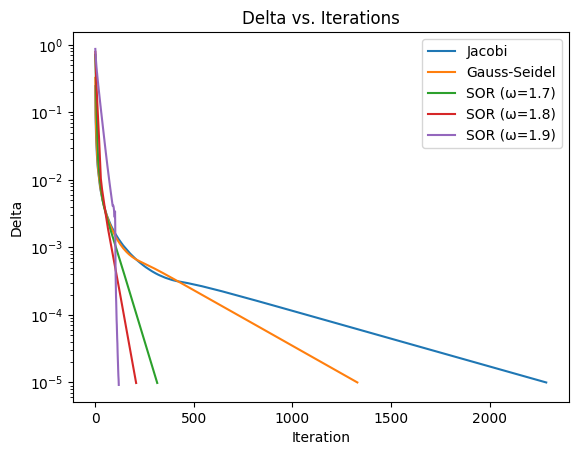

In [ ]:
# Function to count iterations for each method
def track_delta(method, c, omega=None):
    deltas = []
    epsilon = 1e-5
    iteration = 0
    while True:
        c_old = c.copy()
        if method == 'jacobi':
            c = jacobi(c)
        elif method == 'gs':
            c = gauss_seidel(c)
        elif method == 'sor':
            c = sor(c, omega)
        delta = np.max(np.abs(c_old - c))
        deltas.append(delta)
        iteration += 1
        if delta < epsilon:
            break
    return deltas

# Jacobi method
c = np.zeros((Nx+2, Nx+2))  
c[:, 0] = y  
c[:, -1] = y 
delta_jacobi = track_delta('jacobi', c.copy())

# Gauss-Seidel method 
c = np.zeros((Nx+2, Nx+2))  
c[:, 0] = y  
c[:, -1] = y 
delta_gs = track_delta('gs', c.copy())

# SOR method tested with many omega valces
omega_values = [1.7, 1.8, 1.9]
c = np.zeros((Nx+2, Nx+2))  
c[:, 0] = y  
c[:, -1] = y 
delta_sor = {omega: track_delta('sor', c.copy(), omega) for omega in omega_values}

# Plotting deltas against iterations
plt.plot(delta_jacobi, label='Jacobi')
plt.plot(delta_gs, label='Gauss-Seidel')
for omega, deltas in delta_sor.items():
    plt.plot(deltas, label=f'SOR (ω={omega})')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Delta')
plt.title('Delta vs. Iterations')
plt.legend()
plt.show()


J. (1 point) In the SOR method, find the optimal ω. How does it depend on N?.

# Optimize SOR iteration

In [ ]:
# Define grid sizes to test
grid_sizes = [20, 50, 100]  # different N sizes 
omega_range = np.linspace(1.7, 2.0, 5)  # range of omega to test


# find optimal ω for different grid sizes
# def omega_parameter(grid_sizes, omega_range):
optimal_omegas = {}
for Nx in grid_sizes:
    iterations_for_omegas = []
    for omega in omega_range:
        # Setup the grid and boundary conditions again for each N
        c = np.zeros((Nx+2, Nx+2))  
        y_list = np.linspace(0, 1, Nx+2)
        c[:, 0] = y_list  
        c[:, -1] = y_list 
        _, iterations = solve_laplace('sor', c.copy(), omega)
        iterations_for_omegas.append(iterations)
    
    # Omega with least iterations
    min_iterations = min(iterations_for_omegas)
    optimal_omega = omega_range[iterations_for_omegas.index(min_iterations)]
    optimal_omegas[Nx] = (optimal_omega, min_iterations)

    # return optimal_omegas

# Execute the function to find optimal ω for different grid sizes
# best_omega = omega_parameter(grid_sizes, omega_range)
# best_omega

K. (2 points) Implement the possibility to include objects into the computational
domain. The objects should be sinks. Experiment a little bit with some objects in
the computational domain (e.g. a rectangle or a few rectangles, ...). What is the
influence on the number of iterations. What about the optimal ω , is it influenced
by the presence of objects? Look at the resulting concentration fields, and try to
interpret what happens. The implementation in this exercise will also be used for
diffusion-limited aggregation in Set 2.

Converged in 273 iterations


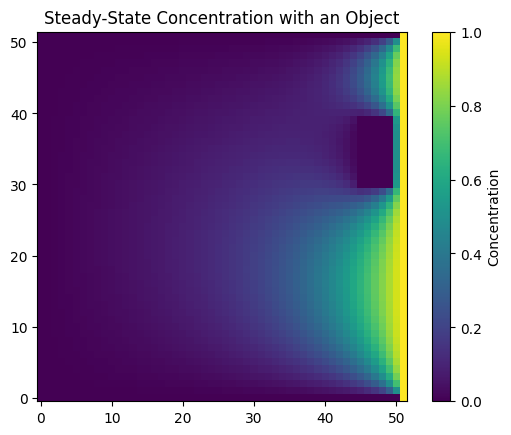

In [ ]:
# Parameters
Nx = 50  # Grid size
omega = 1.7  # Over-relaxation parameter, to be adjusted based on experimentation
epsilon = 1e-5  # Convergence criteria
max_iterations = 10000  # Maximum number of iterations to prevent infinite loops

# Initialize the computational grid
c = np.zeros((Nx+2, Nx+2))
# Boundary conditions
c[:, 0] = 0  # Bottom
c[:, -1] = 1  # Top

# a rectangular object encoded in the domain
objects = np.zeros((Nx+1, Nx+1), dtype=int)
objects[3*Nx//5:4*Nx//5, 9*Nx//10:Nx] = 1  # Representing the object as a rectangle

def update(c, objects):
    c_new = c.copy()
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            if objects[i, j] == 0:  # Check if the point is not part of an object
                c_new[i, j] = (1 - omega) * c[i, j] + (omega / 4) * (
                    c[i+1, j] + c_new[i-1, j] + c[i, j+1] + c_new[i, j-1]
                )
            else:
                c_new[i, j] = 0  # Set concentration to zero if it's part of an object
    return c_new

# Iteration
for iteration in range(max_iterations):
    c_new = update(c, objects)
    # Check for convergence
    delta = np.max(np.abs(c_new - c))
    if delta < epsilon:
        print(f"Converged in {iteration+1} iterations")
        break
    c = c_new
else:
    print("Maximum iterations reached without convergence")

# Plotting
plt.imshow(c, interpolation='nearest', origin='lower')
plt.colorbar(label='Concentration')
plt.title('Steady-State Concentration with an Object')
plt.show()
